In [45]:
### import numpy as np
import gensim
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.utils import np_utils
from IPython.display import SVG
from keras.utils.visualize_util import plot,model_to_dot
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
import pickle
import pandas as pd
import numpy as np

In [46]:
corpora = gensim.corpora.Dictionary.load('./data/corpora.dat')
vocab_size = len(corpora)
print('Number of words in corpora: %d'%(vocab_size))
tmp = list(corpora.items())

Number of words in corpora: 26


In [47]:
#the_filename = './data/wonderland.txt.dat'
the_filename = './data/test.txt.dat'
with open(the_filename, 'rb') as f:
    text = pickle.load(f)

In [48]:
len(text)

30

### Generate words patterns

In [49]:
seq_length = 2

In [50]:
dataX = []
dataY = []

for i in range(0, len(text)-seq_length, 1):
    seq_in = text[i:i+seq_length]
    seq_out = text[i+seq_length]
    dataX.append(seq_in)
    dataY.append(seq_out)

In [51]:
X = np.reshape(dataX, (len(dataX), seq_length, 1))

In [52]:
y = np.array(dataY)

In [53]:
X.shape

(28, 2, 1)

In [54]:
y.shape

(28,)

In [55]:
lstm_1 = LSTM(50, input_shape=(seq_length,1))
#lstm_1 = LSTM(50, input_shape=(y.shape[0], seq_length))

In [56]:
out_layer = Dense(output_dim=vocab_size, activation='softmax')

In [57]:
model = Sequential(layers=[lstm_1, out_layer])

In [58]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [59]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_3 (LSTM)                    (None, 50)            10400       lstm_input_3[0][0]               
____________________________________________________________________________________________________
dense_3 (Dense)                  (None, 26)            1326        lstm_3[0][0]                     
Total params: 11726
____________________________________________________________________________________________________


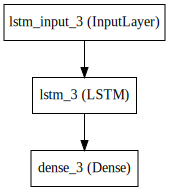

In [60]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [61]:
filepath="test.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')

model.fit(X, y, batch_size=1, nb_epoch=500, callbacks=[checkpoint])
#model.fit(X, y, batch_size=1, nb_epoch=100)

Epoch 1/500
28/28 [==============================] - 0s - loss: 3.4923 - acc: 0.0000e+00     
Epoch 2/500
28/28 [==============================] - 0s - loss: 3.3612 - acc: 0.0000e+00     
Epoch 3/500
28/28 [==============================] - 0s - loss: 3.2789 - acc: 0.1071     
Epoch 4/500
28/28 [==============================] - 0s - loss: 3.2169 - acc: 0.1071     
Epoch 5/500
28/28 [==============================] - 0s - loss: 3.1614 - acc: 0.1429     
Epoch 6/500
28/28 [==============================] - 0s - loss: 3.1095 - acc: 0.1429     
Epoch 7/500
28/28 [==============================] - 0s - loss: 3.0543 - acc: 0.1071     
Epoch 8/500
28/28 [==============================] - 0s - loss: 3.0011 - acc: 0.1786     
Epoch 9/500
28/28 [==============================] - 0s - loss: 2.9450 - acc: 0.1429     
Epoch 10/500
28/28 [==============================] - 0s - loss: 2.8901 - acc: 0.1786     
Epoch 11/500
28/28 [==============================] - 0s - loss: 2.8394 - acc: 0.1786     


In [62]:
scores = model.evaluate(X, y, verbose=0)
print("Model Accuracy: %.2f%%" % (scores[1]*100))

Model Accuracy: 92.86%


### Test prediction

In [63]:
def get_next(inp):
    idxs = [corpora.token2id[c] for c in inp]
    idxs = np.reshape(idxs, (1, seq_length, 1))
    #idxs = idxs / float(len(corpora))
    prediction = model.predict(idxs, verbose=0)
    index = np.argmax(prediction)
    result = corpora.id2token[index]
    return result

In [68]:
get_next(['One', 'two'])

'three'

In [69]:
test_cases_text = pd.read_csv('./data/test_cases_text.csv')
pred = []
for index, row in test_cases_text.iterrows():
    #print( '%s %s'%(row['in_0'], row['in_1']))
    inp = [row['in_0'], row['in_1']]
    #print(inp)
    tmp = get_next(inp)
    pred.append(tmp)
test_cases_text['predicted'] = pred

In [70]:
test_cases_text[test_cases_text.out!=test_cases_text.predicted]

,in_0,in_1,out,predicted
23,you,?,What,you
26,are,you,doing,?


In [71]:
true_cnt = len(test_cases_text[test_cases_text.out==test_cases_text.predicted].index) * 1.0
all_cnt = len(test_cases_text.index) * 1.0
print('True cnt: %d All cnt %d'%(true_cnt, all_cnt))
print("Precision: %.2f"%( true_cnt/all_cnt))

True cnt: 26 All cnt 28
Precision: 0.93
